In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tfd = tf.contrib.distributions
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.set_random_seed(42)

In [2]:
K = 4
eps = 1e-7

In [3]:
# Unnormalized
def mvn_density(X, mu=np.array([[0, 0]]), sig=np.array([[1, 1]])):
    mu = tf.constant(mu, dtype=tf.float32)
    sig = tf.constant(sig, dtype=tf.float32)
    X = X[:, None, :] - mu[None, :, :]
    sig_inv = 1./sig
    exponent = -0.5 * tf.reduce_sum(X * sig_inv[None, :, :] * X, axis=(1, 2))
    return tf.exp(exponent)

In [4]:
def true_density(z):
    return (mvn_density(z, mu=np.array([[0, 3]]), sig= 0.2 * np.array([[1, 2]]))
            + mvn_density(z, mu=np.array([[0, -3]]), sig= 0.2 * np.array([[1, 2]]))
            + mvn_density(z, mu=np.array([[-3, 0]]), sig= 0.2 * np.array([[2, 1]]))
            + mvn_density(z, mu=np.array([[3, 0]]), sig= 0.2 * np.array([[2, 1]])))

In [5]:
m = lambda x: -1 + tf.log(1 + tf.exp(x))
h = lambda x: tf.tanh(x)
h_prime = lambda x: 1 - tf.tanh(x) ** 2
base_dist = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
z_0 = base_dist.sample(500)
z_prev = z_0
sum_log_det_jacob = 0.
for i in range(K):
    with tf.variable_scope('layer_%d' % i):
        u = tf.get_variable('u', dtype=tf.float32, shape=(1, 2))
        w = tf.get_variable('w', dtype=tf.float32, shape=(1, 2))
        b = tf.get_variable('b', dtype=tf.float32, shape=())
        u_hat = (m(tf.tensordot(w, u, 2)) - tf.tensordot(w, u, 2)) * (w / tf.norm(w)) + u
        affine = h_prime(tf.expand_dims(tf.reduce_sum(z_prev * w, -1), -1) + b) * w
        sum_log_det_jacob += tf.log(eps + tf.abs(1 + tf.reduce_sum(affine * u_hat, -1)))
        z_prev = z_prev + u_hat * h(tf.expand_dims(tf.reduce_sum(z_prev * w, -1), -1) + b)
z_k = z_prev
log_q_k = base_dist.log_prob(z_0) - sum_log_det_jacob
log_p = tf.log(eps + true_density(z_k))

kl = tf.reduce_mean(log_q_k - log_p, -1)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [6]:
train_op = tf.train.AdamOptimizer(1e-2).minimize(kl)
init_op = tf.global_variables_initializer()

i: 1000 KL: -0.56767184
i: 2000 KL: -0.5672201
i: 3000 KL: -0.5746906
i: 4000 KL: -0.5614169
i: 5000 KL: -0.590557


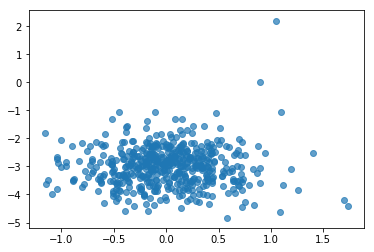

i: 6000 KL: -0.62321526
i: 7000 KL: -0.94635415
i: 8000 KL: -0.98138773
i: 9000 KL: -0.9739027
i: 10000 KL: -1.0575844


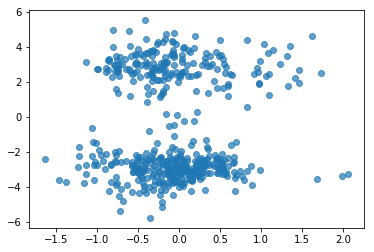

In [7]:
sess = tf.InteractiveSession()
sess.run(init_op)

for i in range(1, 10000 + 1):
    _, kl_np = sess.run([train_op, kl])
    if i % 1000 == 0:
        print('i:', i, 'KL:', kl_np)
    if i % 5000 == 0:
        z_k_np = sess.run(z_k)
        plt.scatter(z_k_np[:, 0], z_k_np[:, 1], alpha=0.7)
        plt.show()

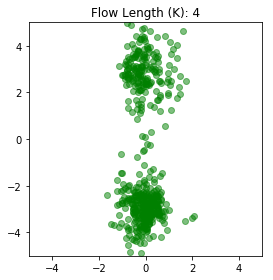

In [8]:
plt.scatter(z_k_np[:, 0], z_k_np[:, 1], alpha=0.5, c='green')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title('Flow Length (K): %d' % K)
plt.tight_layout()
plt.savefig('../report/imgs/example3-k%d.png' % K, dpi=300, bbox_inches='tight')